In [52]:
import os
os.environ['LDFLAGS'] = "-L/opt/homebrew/opt/libomp/lib"
os.environ['CPPFLAGS'] = "-I/opt/homebrew/opt/libomp/include"

# !pip3 install cmake
# !pip3 install --no-cache-dir lightgbm
# !pip3 install lightgbm
# %pip install implicit

In [53]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [54]:
# !pip3 install pandas numpy seaborn matplotlib lightgbm tqdm pickle5

In [55]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [56]:

from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    ALS,
    BPR,
    UserGroupTimeHistory,
    OrderHistoryDecay,
    ItemPair,
    TimeHistory,
    ItemCF,
    UserGroupItemCF
)
from src.retrieval.collector import RuleCollector

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# data_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/data/Vibrent")
# model_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/models/models_Vibrent")
data_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/data/HM")
model_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/models/models_HM")

In [59]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "LargeRecall"
TEST = True # * Set as `False` when do local experiments to save time

In [60]:
TEST_BATCH_SIZE = 70000
TEST_BATCH_NUM = 10 # 1371980 / 70000
# TEST_BATCH_SIZE = 35000
# TEST_BATCH_NUM = 10

In [61]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

Pepare data: encoding ids and preprocessing

In [62]:
dh = DataHelper(data_dir)

In [63]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [64]:
data = dh.load_data(name="encoded_full")

In [65]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [66]:
user_info = data["inter"].groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')
user_info['purchase_ability'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']

In [67]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)
data['user'] = data['user'].merge(user_info, on='customer_id', how='left')

In [ ]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
    train = train.merge(user_info, on='customer_id', how='left')

    train['t_dat'] = pd.to_datetime(train['t_dat'])
    last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
    last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
    last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]
    last_80day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=80)]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            ALS(customer_list, last_60day, n=30, iter_num=40),
            BPR(customer_list, last_80day, n=30, iter_num=100),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=30, scale=True, name='1'),
            UserGroupTimeHistory(data, customer_list, last_week, ['purchase_ability'], n=30, scale=True, name='2'),
            UserGroupTimeHistory(data, customer_list, last_week, ['user_gender'], n=30, scale=True, name='3'),
            OrderHistory(train, days=35, n=30),
            OrderHistoryDecay(train, days=7, n=30),
            TimeHistory(customer_list, last_week, n=30),

            ItemCF(last_80day, last_2week, top_k=10, name='1'),
            ItemCF(last_60day, last_2week, top_k=10, name='2'),
            ItemCF(last_2week, last_2week, top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'age_bins', top_k=10, name='1'),
            UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
            UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'purchase_ability', top_k=10, name='4'),
            UserGroupItemCF(last_60day, last_2week, 'purchase_ability', top_k=10, name='5'),
            UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
        ],

        min_pos_rate=0.006,
        norm=False,
        compress=False,
    )

    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )
    rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
    tmp = candidates[rule_names]
    for f in rule_names:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    candidates['score'] = tmp[rule_names].sum(axis=1)
    del tmp
    gc.collect()
    candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
    candidates = candidates[candidates['rank']<=30]

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")


Week 0: [2020-09-23, 2020-09-30)


Retrieve items by rules: 100%|██████████| 2/2 [00:00<00:00, 84.19it/s]

Positive rate: 0.02500
skip


850

Week 1: [2020-09-16, 2020-09-23)


Retrieve items by rules: 100%|██████████| 2/2 [00:00<00:00, 76.41it/s]

Positive rate: 0.00465
skip


34

Week 2: [2020-09-09, 2020-09-16)


Retrieve items by rules: 100%|██████████| 2/2 [00:00<00:00, 87.30it/s]

Positive rate: 0.01170
skip


34

Week 3: [2020-09-02, 2020-09-09)


Retrieve items by rules: 100%|██████████| 2/2 [00:00<00:00, 90.42it/s]

Positive rate: 0.01724
skip


34

Week 4: [2020-08-26, 2020-09-02)


Retrieve items by rules:   0%|          | 0/2 [00:00<?, ?it/s]

skip


Retrieve items by rules: 100%|██████████| 2/2 [00:00<00:00, 83.71it/s]


skip


AttributeError: 'NoneType' object has no attribute 'memory_usage'

In [ ]:
del train, valid, customer_list, candidates
gc.collect()

20

## Merge Features


In [ ]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")

In [ ]:
#* embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# * embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)
# * embeddings from Word2Vector model
w2v_user_embd = np.load(data_dir/'external'/'w2v_user_embd.npy', allow_pickle=True)
w2v_item_embd = np.load(data_dir/'external'/'w2v_item_embd.npy', allow_pickle=True)

In [ ]:
for col in inter.columns:
    inter[col] = np.nan_to_num(inter[col])
    

In [ ]:
# 
for i in tqdm(range(1)):
    if i == 0 and not TEST:
        continue
    
    if i == 0:
        for j in range(TEST_BATCH_NUM):
            # candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_{j}.pqt")
            candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
            chunk_size = int(candidate.shape[0] * 0.5)

            for chunk, batch in enumerate(range(0, candidate.shape[0], chunk_size)):
                sub_candidate = candidate.iloc[batch:batch+chunk_size-1]
                # * merge features
                sub_candidate = merge_week_data(data, inter, i, sub_candidate)
                # * merge DSSM user and item embeddings
                sub_candidate["dssm_similarity"] = calc_embd_similarity(sub_candidate, dssm_user_embd, dssm_item_embd)
                # * merge YouTubeDNN user and item embeddings
                sub_candidate["yt_similarity"] = calc_embd_similarity(sub_candidate, yt_user_embd, yt_item_embd)
                sub_candidate["wv_similarity"] = calc_embd_similarity(sub_candidate, w2v_user_embd, w2v_item_embd, sub=False)
                
                # Calculate the final score by combining all similarity measures
                similarity_cols = ['dssm_similarity', 'yt_similarity', 'wv_similarity']
                for col in similarity_cols:
                    sub_candidate[col] = MinMaxScaler().fit_transform(sub_candidate[col].values.reshape(-1, 1))
                
                # Combine scores (you can adjust weights if needed)
                sub_candidate['final_score'] = sub_candidate[similarity_cols].sum(axis=1)
                
                # Rank the candidates within each customer_id group
                sub_candidate['rank'] = sub_candidate.groupby('customer_id')['final_score'].rank(ascending=False, method='first')
                
                # Keep only top N candidates (adjust N as needed)
                sub_candidate = sub_candidate[sub_candidate['rank'] <= 30]
                
                print(f"Chunk {chunk} done...")
                print("Columns in candidate:", candidate.columns.tolist())  # Kiểm tra các cột trước khi lưu
                sub_candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_{j}_{chunk}.pqt")
                gc.collect()
    else:
        candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
        # * merge features
        candidate = merge_week_data(data, inter, i, candidate)
        print(candidate['week'].unique())
        # * merge DSSM user and item embeddings
        candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
        # * merge YouTubeDNN user and item embeddings
        candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
        
        # Calculate the final score by combining all similarity measures
        similarity_cols = ['dssm_similarity', 'yt_similarity']
        for col in similarity_cols:
            candidate[col] = MinMaxScaler().fit_transform(candidate[col].values.reshape(-1, 1))
        
        # Combine scores (you can adjust weights if needed)
        candidate['final_score'] = candidate[similarity_cols].sum(axis=1)
        
        # Rank the candidates within each customer_id group
        candidate['rank'] = candidate.groupby('customer_id')['final_score'].rank(ascending=False, method='first')
        # Keep only top N candidates (adjust N as needed)
        candidate = candidate[candidate['rank'] <= 30]
        print("Columns in candidate:", candidate.columns.tolist())  # Kiểm tra các cột trước khi lưu
        candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

In [ ]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

0

## Ranking


In [ ]:
candidates = {}
labels = {}
# for i in tqdm(range(1, WEEK_NUM)):
#     candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    
#     candidates[i] = candidates[i][candidates[i]['rank']<=20]
#     labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")
# First inspect one file to see what columns exist
sample = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week1_candidate.pqt")
print("Available columns:", sample.columns.tolist())

# Then modify your code accordingly
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    
    # Use whatever scoring column actually exists in your data
    if 'score' in candidates[i].columns:  # or 'final_score' or other column name
        candidates[i]['rank'] = candidates[i].groupby('customer_id')['score'].rank(ascending=False)
        candidates[i] = candidates[i][candidates[i]['rank'] <= 30]
    
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

Available columns: ['customer_id', 'article_id', 'ItemPairRetrieve_1', 'ItemPairRetrieve_2', 'ItemPairRetrieve_3', 'ItemPairRetrieve_4', 'OrderHistoryDecay_1', 'OrderHistoryDecay_2', 'OrderHistory_1', 'OrderHistory_2', 'SaleTrend_1', 'TimeHistoryDecay_1', 'TimeHistoryDecay_2', 'TimeHistory_1', 'TimeHistory_2', 'UGSaleTrend_1', 'UGTimeHistory_1', 'UGTimeHistory_2', 'label', 'week', 't_dat', 'price', 'sales_channel_id', 'valid', 'product_code', 'i_1w_sale_rank', 'i_1w_sale_norm', 'p_1w_sale_rank', 'p_1w_sale_norm', 'i_2w_sale', 'i_2w_sale_rank', 'i_2w_sale_norm', 'p_2w_sale', 'p_2w_sale_rank', 'p_2w_sale_norm', 'i_3w_sale', 'i_3w_sale_rank', 'i_3w_sale_norm', 'p_3w_sale', 'p_3w_sale_rank', 'p_3w_sale_norm', 'i_4w_sale', 'i_4w_sale_rank', 'i_4w_sale_norm', 'p_4w_sale', 'p_4w_sale_rank', 'p_4w_sale_norm', 'i_repurchase_ratio', 'p_repurchase_ratio', 'i_sale', 'p_sale', 'i_sale_uni', 'p_sale_uni', 'lw_i_sale', 'lw_p_sale', 'lw_i_sale_uni', 'lw_p_sale_uni', 'i_sale_ratio', 'i_sale_uni_ratio',

100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


In [ ]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "valid",
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",

    "user_gender",
    "article_gender",
    "season_type"
]

In [ ]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:01<00:00, 11.11it/s]


In [ ]:
full_data = pd.concat([candidates[i] for i in range(1, WEEK_NUM)], ignore_index=True)

### Extra Features

In [ ]:
inter = data['inter']
inter = inter[inter['t_dat']<'2020-08-19'] # * start date of the last valid week
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
inter = inter.merge(data['item'][["article_id", "product_code"]], on="article_id", how="left")

In [ ]:
tmp = inter.groupby('article_id').week.mean()
full_data['article_time_mean'] = full_data['article_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(-1)
full_data['customer_id_last_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(0)
full_data['customer_id_first_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.mean()
full_data['customer_id_time_mean'] = full_data['customer_id'].map(tmp)

full_data['customer_id_gap'] = full_data['customer_id_first_time'] - full_data['customer_id_last_time']

tmp = inter.groupby('customer_id').size()
full_data['customer_daily_bought'] = full_data['customer_id'].map(tmp) / full_data['customer_id_gap']

tmp = inter.groupby('customer_id').price.median()
full_data['customer_id_price_median'] = full_data['customer_id'].map(tmp)

full_data['customer_article_price_gap'] = full_data['customer_id_price_median'] - full_data['price']

del tmp
gc.collect()

from itertools import chain
def dict_union(L):
    return dict(chain.from_iterable(d.items() for d in L))

dur = [52]
for col in tqdm(["article_id","product_code"]):
    full_data[f'{col}_id_week'] = full_data[col].astype('str') + '_' + full_data['week'].astype('str')

    for j in dur:
        dict_list = []
        for i in range(5):
            tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
            
            tmp['week'] = i+1
            tmp = tmp.groupby(['week', col]).size().reset_index()
            tmp.columns = ['week', col, 'count_sales']

            tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

            dict_list.append( dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])) )
            del tmp

        dict_all = dict_union(dict_list)
        full_data[f'{col}_week_shift{j}'] = full_data[f'{col}_id_week'].map(dict_all)

        del dict_all
    gc.collect()

full_data['article_id_week_1/52'] = full_data['i_sale'] / full_data[f'article_id_week_shift52']
full_data['product_code_week_1/52'] = full_data['i_sale'] / full_data[f'product_code_week_shift52']

0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:15<00:15, 15.11s/it]

0

100%|██████████| 2/2 [00:28<00:00, 14.34s/it]


In [ ]:
feats += [
    'article_time_mean', 
    'customer_id_last_time', 
    'customer_id_first_time', 
    'customer_id_time_mean',
    'customer_id_gap',
    'customer_id_price_median',
    'customer_daily_bought',
    'customer_article_price_gap'
] + [f'{col}_week_shift{j}' for col in ["article_id","product_code"] for j in dur] +\
['article_id_week_1/52', 'product_code_week_1/52']

### Train


In [ ]:
for feat in tqdm(cat_features):
    full_data[feat] = full_data[feat].astype(cate_dict[feat])

100%|██████████| 17/17 [00:04<00:00,  3.85it/s]


In [ ]:
train = full_data.loc[full_data['week']>1]
valid = full_data.loc[full_data['week']==1]

del full_data
gc.collect()

0

In [ ]:
params = {
    "objective": "binary", #"lambdarank",
    "boosting_type": "gbdt",
    "metric": "auc", #"map",
    "max_depth":8,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [ ]:
def train_rank_model(train, valid, train_group, valid_group):

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

      # Huấn luyện mô hình với callbacks bao gồm early_stopping
    ranker = lgb.train(
        params=params,
        train_set=train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        valid_names=["valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),  # Dừng sớm sau 30 vòng không cải thiện
            lgb.log_evaluation(period=10),  # Log every 10 iterations
        ],
    )
    ranker.save_model(
        model_dir / f"lgb_large_ranker.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
def train_binary_model(train, valid):
    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

   # Huấn luyện mô hình với các callbacks
    ranker = lgb.train(
        params=params,
        train_set=train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        valid_names=["valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),  # Dừng sớm nếu không cải thiện sau 30 vòng
            lgb.log_evaluation(period=10),  # Log mỗi 10 vòng
        ],
    )
    ranker.save_model(
        model_dir / "lgb_large_binary.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
del candidates
gc.collect()

0

In [ ]:
print("Train positive rate:", train.label.mean())

Train positive rate: 0.0067018773363074985


In [ ]:
# * Ignore customers with full negative samples
train['customer_id'] = train['customer_id'].astype(int)
train['week_customer_id'] = train['customer_id'].astype(str) + '_' + train['week'].astype(str)
valid_uids = train.groupby('week_customer_id')['label'].sum().reset_index(name='sum')
train = train[train['week_customer_id'].isin(valid_uids.loc[valid_uids['sum'] > 0, 'week_customer_id'])]
del train['week_customer_id']
train['customer_id'] = train['customer_id'].astype(cate_dict['customer_id'])
print("Train positive rate:", train.label.mean())

Train positive rate: 0.03133030412951755


In [ ]:
train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(drop=True)
valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)

In [ ]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
train_group = (train_group.groupby(["week", "customer_id"]).size().values)

In [ ]:
valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
valid_group = valid_group.groupby(["customer_id"]).size().values

In [ ]:
train = train[feats+['label']]
valid = valid[feats+['label']]

In [ ]:
gc.collect()

0

In [ ]:
ranker = train_rank_model(train, valid, train_group, valid_group)
# ranker = train_binary_model(train, valid)

Training until validation scores don't improve for 30 rounds
[10]	valid's auc: 0.673298
[20]	valid's auc: 0.675205
[30]	valid's auc: 0.676053
[40]	valid's auc: 0.677455
[50]	valid's auc: 0.680212
[60]	valid's auc: 0.681104
[70]	valid's auc: 0.681467
[80]	valid's auc: 0.682362
[90]	valid's auc: 0.682129
[100]	valid's auc: 0.682297
[110]	valid's auc: 0.682297
Early stopping, best iteration is:
[81]	valid's auc: 0.682636


### Inference

In [ ]:
# ranker = lgb.Booster(model_file=model_dir / "lgb_large_binary.model")
ranker = lgb.Booster(model_file=model_dir / "lgb_large_ranker.model")

<Figure size 800x2400 with 0 Axes>

<Axes: xlabel='importance', ylabel='feature'>

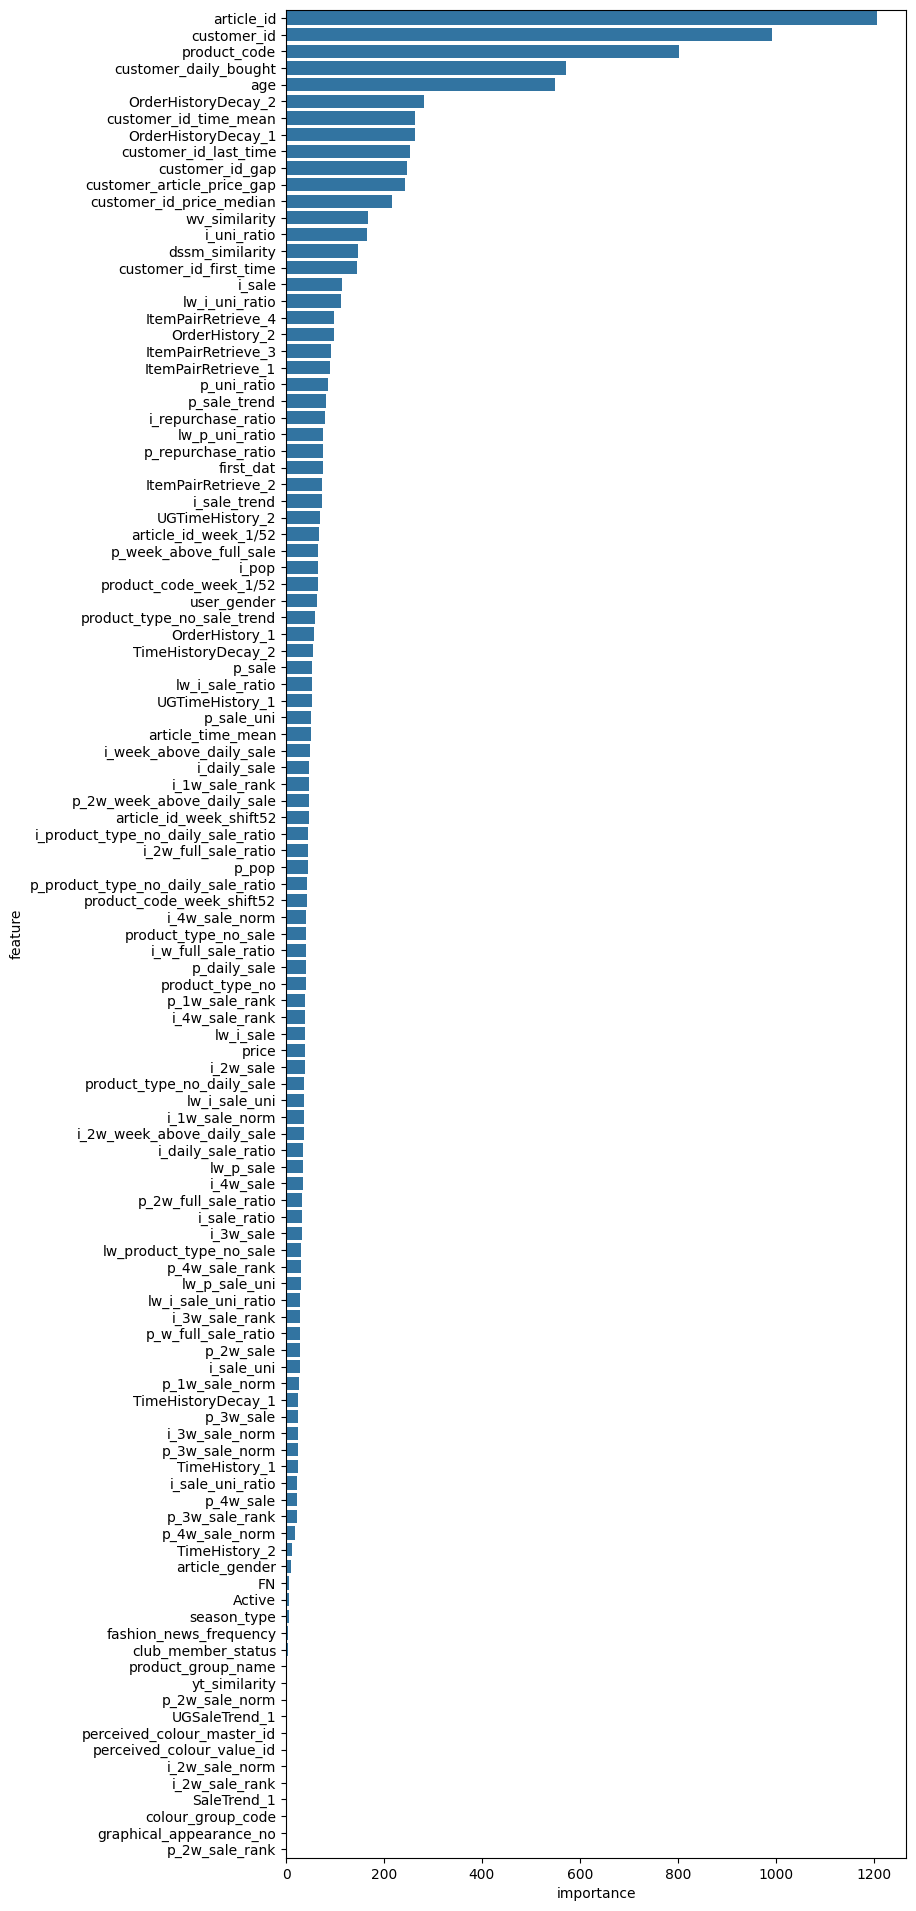

In [ ]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 24))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [ ]:
val_candidates = valid.reset_index(drop=True)

In [ ]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [ ]:
pred = predict(ranker, val_candidates)

  0%|          | 0/68984 [00:00<?, ?it/s]

In [ ]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [ ]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.030474231530210446 ranker, top50
# 0.028997107156740753 binary, top50

0.02901492931326081

In [ ]:
# Recall
recall_at_k(label["article_id"], label["prediction"], k=12)

0.06478467999559323

In [ ]:
#HitRate
hr_at_k(label["article_id"], label["prediction"], k=12)

0.1310303838571263

In [ ]:
batch_size = 7_000_000
probs = np.zeros(val_candidates.shape[0])
for batch in range(0, val_candidates.shape[0], batch_size):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs
val_candidates["prob"] = probs
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [ ]:
# pred_lgb.to_parquet(data_dir/"processed"/"large_binary_valid.pqt")
pred_lgb.to_parquet(data_dir/"processed"/"large_rank_valid.pqt")

In [ ]:
pred_lgb.to_parquet(data_dir/"processed"/"nn_valid.pqt")

### Blend

In [ ]:
pred1_lgb_rank = pd.read_parquet(data_dir/"processed"/"large_rank_valid.pqt")
pred1_lgb_binary = pd.read_parquet(data_dir/"processed"/"large_binary_valid.pqt")


In [ ]:
pred2_lgb_rank = pd.read_parquet(data_dir/"processed"/"small_rank_valid.pqt")
pred2_lgb_binary = pd.read_parquet(data_dir/"processed"/"small_binary_valid.pqt")
pred2_nn = pd.read_parquet(data_dir/"processed"/"nn_valid.pqt")
pred2_nn.rename(columns={'article_id':'prediction'},inplace=True)

In [ ]:
pred2_lgb_binary = pred2_lgb_binary.merge(pred2_nn, on=['customer_id','prediction'], how='left')
pred2_lgb_binary['prob'] = pred2_lgb_binary['prob_x'] + pred2_lgb_binary['prob_y']

In [ ]:
pred1_lgb_rank   = pred1_lgb_rank.sort_values(by='prob', ascending=False).reset_index(drop=True)
pred1_lgb_binary = pred1_lgb_binary.sort_values(by='prob', ascending=False).reset_index(drop=True)
pred2_lgb_rank   = pred2_lgb_rank.sort_values(by='prob', ascending=False).reset_index(drop=True)
pred2_lgb_binary = pred2_lgb_binary.sort_values(by='prob', ascending=False).reset_index(drop=True)

In [ ]:
pred1_lgb_rank   = pred1_lgb_rank.groupby('customer_id')['prediction'].apply(list).reset_index()
pred1_lgb_binary = pred1_lgb_binary.groupby('customer_id')['prediction'].apply(list).reset_index()
pred2_lgb_rank   = pred2_lgb_rank.groupby('customer_id')['prediction'].apply(list).reset_index()
pred2_lgb_binary = pred2_lgb_binary.groupby('customer_id')['prediction'].apply(list).reset_index()

In [ ]:
pred1_lgb_rank.rename(columns={'prediction':'large_rank'},inplace=True)
pred1_lgb_binary.rename(columns={'prediction':'large_binary'},inplace=True)
pred2_lgb_rank.rename(columns={'prediction':'small_rank'},inplace=True)
pred2_lgb_binary.rename(columns={'prediction':'small_binary'},inplace=True)

In [ ]:
pred = pred1_lgb_rank.merge(pred1_lgb_binary, on=['customer_id'])\
                    .merge(pred2_lgb_rank, on=['customer_id'])\
                    .merge(pred2_lgb_binary, on=['customer_id'])

In [ ]:
def cust_blend(dt, W = [1,1,1,1]):
    #Create a list of all model predictions
    REC = []

    # Second Try
    REC.append(dt['large_rank'])
    REC.append(dt['large_binary'])
    REC.append(dt['small_rank'])
    REC.append(dt['small_binary'])

    #Create a dictionary of items recommended.
    #Assign a weight according the order of appearance and multiply by global weights
    res = {}
    for M in range(len(REC)):
        for n, v in enumerate(REC[M]):
            if v in res:
                res[v] += (W[M]/(n+1))
            else:
                res[v] = (W[M]/(n+1))

    # Sort dictionary by item weights
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())

    # Return the top 12 items only
    return res

In [ ]:
pred['prediction'] = pred.progress_apply(cust_blend, W = [1.0, 1.0, 1.0, 1.0], axis=1)

  0%|          | 0/68984 [00:00<?, ?it/s]

In [ ]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [ ]:
map_at_k(label["article_id"], label["prediction"], k=12)


0.02918998808346185

In [ ]:
# Recall
recall_at_k(label["article_id"], label["prediction"], k=12)

0.06535349561717374

In [ ]:
#HitRate
hr_at_k(label["article_id"], label["prediction"], k=12)

0.13204511191000812

### Test

In [ ]:
# files = os.listdir(data_dir/"processed"/VERSION_NAME)
# for batch in range(TEST_BATCH_NUM):
#     chunk_files = [f for f in files if f.startswith(f"week0_candidate_{batch}")]
#     for chunk,chunk_file in enumerate(sorted(chunk_files)):
#         print(chunk_file)
#         test_candidate = pd.read_parquet(data_dir/"processed"/VERSION_NAME/chunk_file)
#         test_candidate = test_candidate[test_candidate['rank']<=20].reset_index(drop=True)
#         # * ============================================================================================

#         tmp = inter.groupby('article_id').week.mean()
#         test_candidate['article_time_mean'] = test_candidate['article_id'].map(tmp)

#         tmp = inter.groupby('customer_id').week.nth(-1)
#         test_candidate['customer_id_last_time'] = test_candidate['customer_id'].map(tmp)

#         tmp = inter.groupby('customer_id').week.nth(0)
#         test_candidate['customer_id_first_time'] = test_candidate['customer_id'].map(tmp)

#         tmp = inter.groupby('customer_id').week.mean()
#         test_candidate['customer_id_time_mean'] = test_candidate['customer_id'].map(tmp)

#         test_candidate['customer_id_gap'] = test_candidate['customer_id_first_time'] - test_candidate['customer_id_last_time']

#         tmp = inter.groupby('customer_id').size()
#         test_candidate['customer_daily_bought'] = test_candidate['customer_id'].map(tmp) / test_candidate['customer_id_gap']

#         tmp = inter.groupby('customer_id').price.median()
#         test_candidate['customer_id_price_median'] = test_candidate['customer_id'].map(tmp)

#         test_candidate['customer_article_price_gap'] = test_candidate['customer_id_price_median'] - test_candidate['price']

#         del tmp
#         gc.collect()

#         from itertools import chain
#         def dict_union(L):
#             return dict(chain.from_iterable(d.items() for d in L))

#         dur = [52]
#         for col in tqdm(["article_id","product_code"]):
#             test_candidate[f'{col}_id_week'] = test_candidate[col].astype('str') + '_' + test_candidate['week'].astype('str')

#             for j in dur:
#                 dict_list = []
#                 for i in range(5):
#                     tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
                    
#                     tmp['week'] = i+1
#                     tmp = tmp.groupby(['week', col]).size().reset_index()
#                     tmp.columns = ['week', col, 'count_sales']

#                     tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

#                     dict_list.append( dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])) )
#                     del tmp

#                 dict_all = dict_union(dict_list)
#                 test_candidate[f'{col}_week_shift{j}'] = test_candidate[f'{col}_id_week'].map(dict_all)

#                 del dict_all
#             gc.collect()

#         test_candidate['article_id_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'article_id_week_shift52']
#         test_candidate['product_code_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'product_code_week_shift52']

#         # * =================================================================================================================

#         for feat in cat_features:
#             test_candidate[feat] = test_candidate[feat].astype(cate_dict[feat])

#         batch_size = 5_000_000
#         probs = np.zeros(test_candidate.shape[0])
#         for mini_batch in tqdm(range(0, test_candidate.shape[0], batch_size)):
#             outputs = ranker.predict(test_candidate.loc[mini_batch : mini_batch + batch_size - 1, feats])
#             probs[mini_batch : mini_batch + batch_size] = outputs
#         test_candidate["prob"] = probs
#         pred_lgb = test_candidate[['customer_id','article_id','prob']]
#         pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
#         pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
#         pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
#         pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

#         # pred_lgb.to_parquet(data_dir/"interim"/VERSION_NAME/f"large_binary_test_{batch}_{chunk}.pqt")
#         pred_lgb.to_parquet(data_dir/"interim"/VERSION_NAME/f"large_rank_test_{batch}_{chunk}.pqt")

#         del test_candidate
#         gc.collect()
files = os.listdir(data_dir/"processed"/VERSION_NAME)
    
for batch in range(TEST_BATCH_NUM):
        chunk_files = [f for f in files if f.startswith(f"week0_candidate_{batch}")]
        
        for chunk, chunk_file in enumerate(sorted(chunk_files)):
            print(f"Processing {chunk_file}")
            
            # Load candidate data
            test_candidate = pd.read_parquet(data_dir/"processed"/VERSION_NAME/chunk_file)
            
            # Check and handle rank column
            if 'rank' not in test_candidate.columns:
                print(f"Warning: 'rank' column not found in {chunk_file}")
                
                # Try to create rank from available score columns
                score_cols = ['score', 'final_score', 'prediction_score']  # add possible score column names
                found_score = None
                
                for col in score_cols:
                    if col in test_candidate.columns:
                        found_score = col
                        break
                
                if found_score:
                    print(f"Creating rank from {found_score} column")
                    test_candidate['rank'] = test_candidate.groupby('customer_id')[found_score].rank(ascending=False)
                    test_candidate = test_candidate[test_candidate['rank'] <= 30].reset_index(drop=True)
                else:
                    print("No suitable score column found. Skipping rank filtering.")
            else:
                test_candidate = test_candidate[test_candidate['rank'] <= 30].reset_index(drop=True)
            
            # Feature Engineering
            # Time-based features
            tmp = inter.groupby('article_id').week.mean()
            test_candidate['article_time_mean'] = test_candidate['article_id'].map(tmp)

            tmp = inter.groupby('customer_id').week.nth(-1)
            test_candidate['customer_id_last_time'] = test_candidate['customer_id'].map(tmp)

            tmp = inter.groupby('customer_id').week.nth(0)
            test_candidate['customer_id_first_time'] = test_candidate['customer_id'].map(tmp)

            tmp = inter.groupby('customer_id').week.mean()
            test_candidate['customer_id_time_mean'] = test_candidate['customer_id'].map(tmp)

            test_candidate['customer_id_gap'] = test_candidate['customer_id_first_time'] - test_candidate['customer_id_last_time']

            tmp = inter.groupby('customer_id').size()
            test_candidate['customer_daily_bought'] = test_candidate['customer_id'].map(tmp) / test_candidate['customer_id_gap']

            tmp = inter.groupby('customer_id').price.median()
            test_candidate['customer_id_price_median'] = test_candidate['customer_id'].map(tmp)

            test_candidate['customer_article_price_gap'] = test_candidate['customer_id_price_median'] - test_candidate['price']

            del tmp
            gc.collect()

            # Time-shifted features
            dur = [52]
            for col in tqdm(["article_id","product_code"], desc="Creating time-shifted features"):
                test_candidate[f'{col}_id_week'] = test_candidate[col].astype('str') + '_' + test_candidate['week'].astype('str')

                for j in dur:
                    dict_list = []
                    for i in range(5):
                        tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
                        
                        tmp['week'] = i+1
                        tmp = tmp.groupby(['week', col]).size().reset_index()
                        tmp.columns = ['week', col, 'count_sales']

                        tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

                        dict_list.append(dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])))
                        del tmp

                    dict_all = dict_union(dict_list)
                    test_candidate[f'{col}_week_shift{j}'] = test_candidate[f'{col}_id_week'].map(dict_all)

                    del dict_all
                gc.collect()

            test_candidate['article_id_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'article_id_week_shift52']
            test_candidate['product_code_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'product_code_week_shift52']

            # Handle categorical features
            for feat in cat_features:
                if feat in test_candidate.columns:
                    test_candidate[feat] = test_candidate[feat].astype(cate_dict[feat])
                else:
                    print(f"Warning: Categorical feature {feat} not found in data")

            # Batch prediction
            batch_size = 5_000_000
            probs = np.zeros(test_candidate.shape[0])
            
            # Ensure we only use features that exist in both model and data
            available_feats = [f for f in feats if f in test_candidate.columns]
            missing_feats = [f for f in feats if f not in test_candidate.columns]
            
            if missing_feats:
                print(f"Warning: {len(missing_feats)} features missing in test data. Setting to 0.")
                for f in missing_feats:
                    test_candidate[f] = 0.0
                available_feats = feats  # Now all features are available
            
            for mini_batch in tqdm(range(0, test_candidate.shape[0], batch_size), desc="Making predictions"):
                batch_end = min(mini_batch + batch_size, test_candidate.shape[0])
                outputs = ranker.predict(test_candidate.iloc[mini_batch:batch_end][available_feats])
                probs[mini_batch:batch_end] = outputs
            
            test_candidate["prob"] = probs
            
            # Prepare final predictions
            pred_lgb = test_candidate[['customer_id','article_id','prob']]
            pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
            pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
            pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
            pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

            # Save predictions
            pred_lgb.to_parquet(data_dir/"interim"/VERSION_NAME/f"large_rank_test_{batch}_{chunk}.pqt")

            del test_candidate, pred_lgb, probs
            gc.collect()


Processing week0_candidate_0.pqt
No suitable score column found. Skipping rank filtering.


18

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:24<00:24, 24.81s/it]

0

Making predictions: 100%|██████████| 6/6 [01:06<00:00, 11.13s/it]


4

Processing week0_candidate_0_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:19<00:19, 19.39s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:36<00:00, 18.45s/it]


Making predictions: 100%|██████████| 5/5 [00:50<00:00, 10.11s/it]


4

Processing week0_candidate_0_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:19<00:19, 19.67s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:36<00:00, 18.47s/it]


Making predictions: 100%|██████████| 5/5 [00:45<00:00,  9.02s/it]


4

Processing week0_candidate_0_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:07<00:07,  7.77s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:12<00:00,  6.26s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


4

Processing week0_candidate_1.pqt
No suitable score column found. Skipping rank filtering.


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:23<00:23, 23.33s/it]

0

Making predictions: 100%|██████████| 6/6 [01:01<00:00, 10.25s/it]


4

Processing week0_candidate_10_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:14<00:14, 14.51s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:26<00:00, 13.03s/it]


Making predictions: 100%|██████████| 3/3 [00:22<00:00,  7.42s/it]


4

Processing week0_candidate_10_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:14<00:14, 14.47s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:25<00:00, 12.93s/it]


Making predictions: 100%|██████████| 3/3 [00:22<00:00,  7.46s/it]


4

Processing week0_candidate_10_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:06<00:06,  6.58s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


4

Processing week0_candidate_11_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:13<00:13, 13.35s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:24<00:00, 12.42s/it]


Making predictions: 100%|██████████| 3/3 [00:21<00:00,  7.23s/it]


4

Processing week0_candidate_11_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:13<00:13, 13.25s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:24<00:00, 12.36s/it]


Making predictions: 100%|██████████| 3/3 [00:21<00:00,  7.12s/it]


4

Processing week0_candidate_11_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:06<00:06,  6.59s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


4

Processing week0_candidate_12_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:13<00:13, 13.32s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:24<00:00, 12.47s/it]


Making predictions: 100%|██████████| 3/3 [00:22<00:00,  7.37s/it]


4

Processing week0_candidate_12_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:13<00:13, 13.79s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:25<00:00, 12.69s/it]


Making predictions: 100%|██████████| 3/3 [00:21<00:00,  7.25s/it]


4

Processing week0_candidate_12_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:06<00:06,  6.67s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:11<00:00,  5.72s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


4

Processing week0_candidate_13_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:13<00:13, 13.33s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:24<00:00, 12.42s/it]


Making predictions: 100%|██████████| 3/3 [00:21<00:00,  7.05s/it]


4

Processing week0_candidate_1_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:19<00:19, 19.56s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [17:54<00:00, 537.14s/it]


Making predictions: 100%|██████████| 5/5 [17:36<00:00, 211.32s/it]


4

Processing week0_candidate_1_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:19<00:19, 19.45s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:35<00:00, 17.98s/it]


Making predictions: 100%|██████████| 5/5 [17:42<00:00, 212.56s/it]


4

Processing week0_candidate_1_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:07<00:07,  7.50s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:12<00:00,  6.01s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


4

Processing week0_candidate_2_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:18<00:18, 18.56s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:34<00:00, 17.41s/it]


Making predictions: 100%|██████████| 5/5 [15:54<00:00, 191.00s/it]


4

Processing week0_candidate_2_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:18<00:18, 18.88s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:35<00:00, 17.63s/it]


Making predictions: 100%|██████████| 5/5 [15:02<00:00, 180.49s/it]


4

Processing week0_candidate_2_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:07<00:07,  7.90s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:12<00:00,  6.29s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


4

Processing week0_candidate_3_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:19<00:19, 19.50s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:36<00:00, 18.41s/it]


Making predictions: 100%|██████████| 5/5 [00:45<00:00,  9.08s/it]


4

Processing week0_candidate_3_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [25:34<25:34, 1534.92s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [25:53<00:00, 776.64s/it] 


Making predictions: 100%|██████████| 5/5 [00:49<00:00,  9.86s/it]


4

Processing week0_candidate_3_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:07<00:07,  7.73s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:12<00:00,  6.25s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


4

Processing week0_candidate_4_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:19<00:19, 19.47s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:37<00:00, 18.53s/it]


Making predictions: 100%|██████████| 5/5 [00:51<00:00, 10.35s/it]


4

Processing week0_candidate_4_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:20<00:20, 20.09s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:37<00:00, 18.54s/it]


Making predictions: 100%|██████████| 5/5 [00:50<00:00, 10.05s/it]


4

Processing week0_candidate_4_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:07<00:07,  7.91s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:12<00:00,  6.44s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


4

Processing week0_candidate_5_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:20<00:20, 20.24s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:37<00:00, 18.84s/it]


Making predictions: 100%|██████████| 5/5 [00:50<00:00, 10.14s/it]


4

Processing week0_candidate_5_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:20<00:20, 20.14s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:37<00:00, 18.81s/it]


Making predictions: 100%|██████████| 5/5 [00:49<00:00,  9.90s/it]


4

Processing week0_candidate_5_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:07<00:07,  7.91s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:12<00:00,  6.40s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


4

Processing week0_candidate_6_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:19<00:19, 19.92s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:37<00:00, 18.82s/it]


Making predictions: 100%|██████████| 5/5 [00:49<00:00,  9.94s/it]


4

Processing week0_candidate_6_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:20<00:20, 20.53s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:38<00:00, 19.09s/it]


Making predictions: 100%|██████████| 5/5 [00:50<00:00, 10.08s/it]


4

Processing week0_candidate_6_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:08<00:08,  8.34s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:13<00:00,  6.60s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


4

Processing week0_candidate_7_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:20<00:20, 20.32s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:37<00:00, 18.98s/it]


Making predictions: 100%|██████████| 5/5 [00:49<00:00,  9.92s/it]


4

Processing week0_candidate_7_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:19<00:19, 19.98s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:37<00:00, 18.72s/it]


Making predictions: 100%|██████████| 5/5 [00:49<00:00,  9.82s/it]


4

Processing week0_candidate_7_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:07<00:07,  7.93s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:12<00:00,  6.41s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


4

Processing week0_candidate_8_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:20<00:20, 20.06s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:37<00:00, 18.78s/it]


Making predictions: 100%|██████████| 5/5 [00:48<00:00,  9.63s/it]


4

Processing week0_candidate_8_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:20<00:20, 20.16s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:37<00:00, 18.96s/it]


Making predictions: 100%|██████████| 5/5 [00:48<00:00,  9.76s/it]


4

Processing week0_candidate_8_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:08<00:08,  8.10s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:13<00:00,  6.50s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


4

Processing week0_candidate_9_0.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:21<00:21, 21.15s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:39<00:00, 19.71s/it]


Making predictions: 100%|██████████| 5/5 [00:48<00:00,  9.78s/it]


4

Processing week0_candidate_9_1.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:20<00:20, 20.80s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:39<00:00, 19.70s/it]


Making predictions: 100%|██████████| 5/5 [00:52<00:00, 10.47s/it]


4

Processing week0_candidate_9_2.pqt


0

Creating time-shifted features:   0%|          | 0/2 [00:00<?, ?it/s]

0

Creating time-shifted features:  50%|█████     | 1/2 [00:07<00:07,  7.90s/it]

0

Creating time-shifted features: 100%|██████████| 2/2 [00:12<00:00,  6.42s/it]


Making predictions: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


4

In [ ]:
files = os.listdir(data_dir/"interim"/VERSION_NAME)
chunk_files = [f for f in files if f.startswith("large_rank_test")]

In [ ]:
test_l = []
for f in tqdm(chunk_files):
    tmp_df = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f)
    test_l.append(tmp_df)

100%|██████████| 42/42 [00:11<00:00,  3.51it/s]


In [ ]:
test_pred = pd.concat(test_l, ignore_index=True)

In [ ]:
test_pred['customer_id'].nunique()

1371980

In [ ]:
test_pred.to_parquet(data_dir/"processed"/"large_rank_test.pqt")